# Settings

In [142]:
USE_ALIGNZERO_GLOBAL = 0 
USE_ALIGNZERO_LOCAL = 0
USE_OFFSET = 1 
offset = 0.1
USE_BANDPASS = 1 
USE_NOTCH = 1
USE_ENVELOPE = 0
USE_ZSCORE = 0 
USE_SCALING = 0 

# USE_ALIGNZERO_GLOBAL = Substract the mean to each channel
# USE_ALIGNZERO_LOCAL 
# USE_OFFSET = Generate more windows with offset
# offset 
# USE_BANDPASS = Filter with bandpass (window by window)
# USE_ZSCORE = Filter with zscore (window by window)
# USE_SCALING = Use feature scaling

print("Settings updated")

Settings updated


# Get raw data

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import os

base_paths = [
    "C:/Quick_Disk/tonge_project/data/Recordings_Individual_Classes1", # sesion 1
    "C:/Quick_Disk/tonge_project/data/Recordings_Individual_Classes2", # sesion 2
    "C:/Quick_Disk/tonge_project/data/Recordings_Individual_Classes3" # sesion 3
]

# ------- Get information from individual classes
class_labels = ['none', 'left', 'left_front', 'front', 'right_front', 'right', 'swallow']

sampling_rate = 250  # Hz

all_data = []

for session_id, base_path in enumerate(base_paths, start=1):
    for class_label in class_labels:
        file_path = os.path.join(base_path, f"{class_label}.csv")
        
        try:
            # Get data from one recording and one session
            df = pd.read_csv(file_path, sep='\t', skiprows=5, engine='python')
            df.columns = [f"ch_{i}" for i in range(df.shape[1])]  # standardize column names

            # Store session 
            df["label"] = class_label
            df["session"] = session_id
            
            all_data.append(df)
        except Exception as e:
            print(f"Error reading {file_path}: {e}")
    print(f"Processed session: {session_id}")

# Concatenates all df vertically (axis = 0)
# Reset index means that the indexes are reset globally
# FORMAT: [ch_0, ch_1..., session] 
combined_df = pd.concat(all_data, axis=0).reset_index(drop=True)

print(f"One class combined data shape: {combined_df.shape}")

if USE_ALIGNZERO_GLOBAL == 1:
    channels = ["ch_1", "ch_2", "ch_3"]
    channel_means = combined_df[channels].mean() # Gets df with only those channels, and calculates the mean for each of the columns. 
    for ch in channels:
        combined_df[ch] = combined_df[ch] - channel_means[ch]


Processed session: 1
Processed session: 2
Processed session: 3
One class combined data shape: (877942, 26)


## Plot raw data & annotations

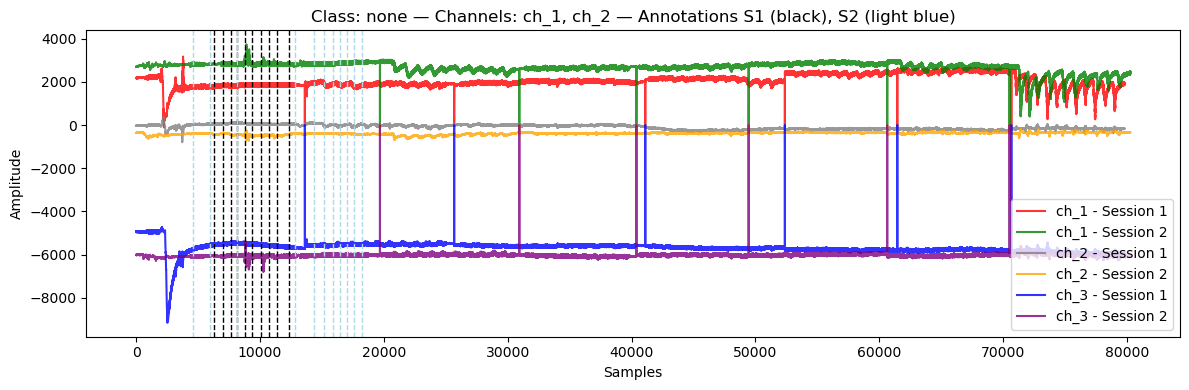

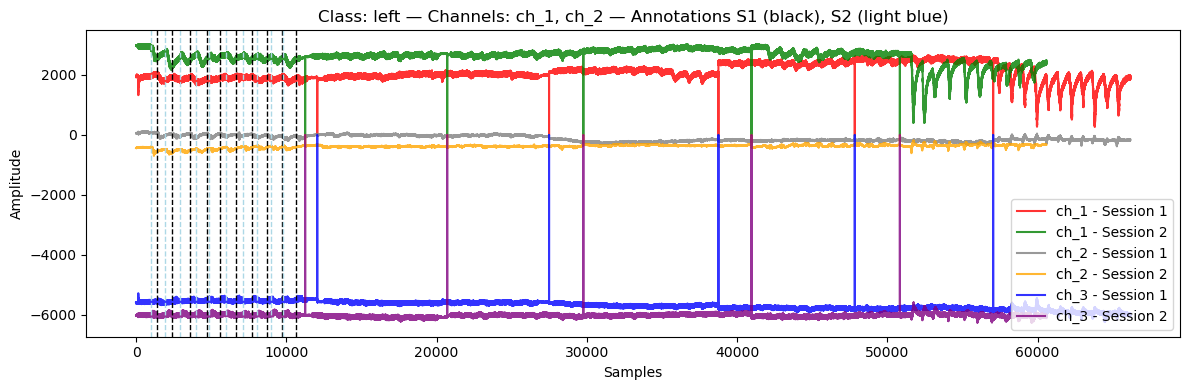

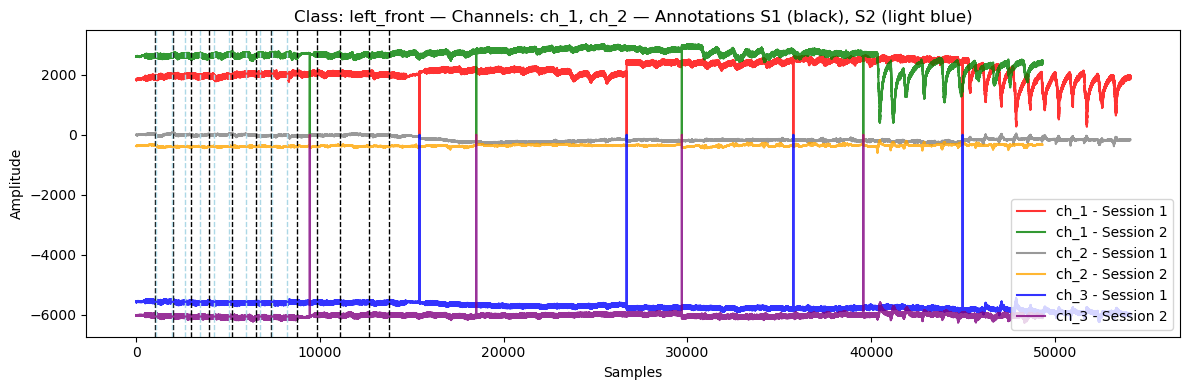

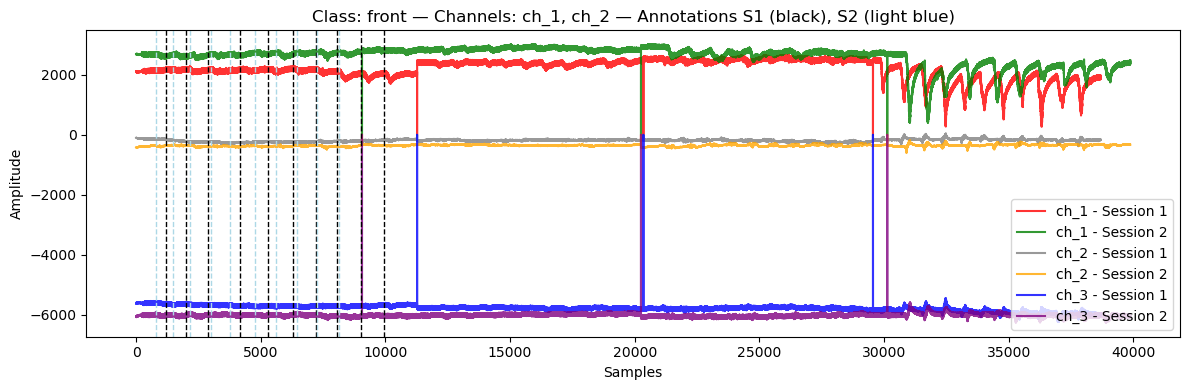

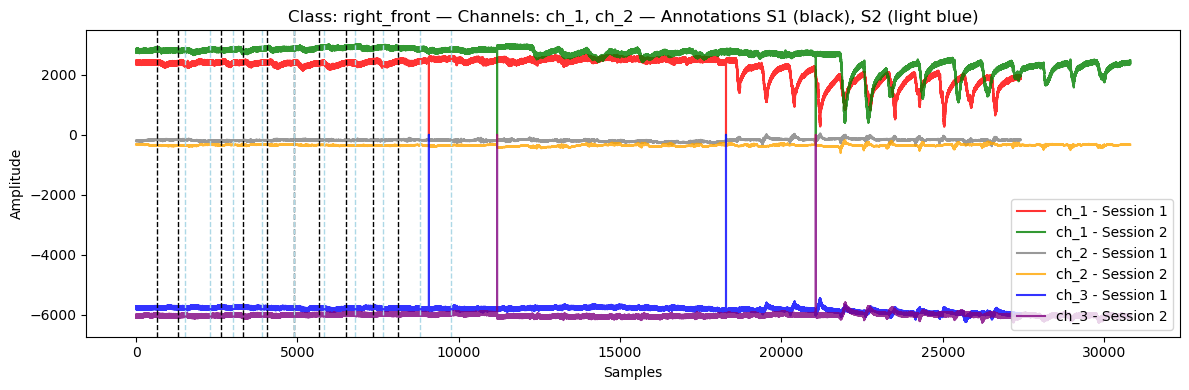

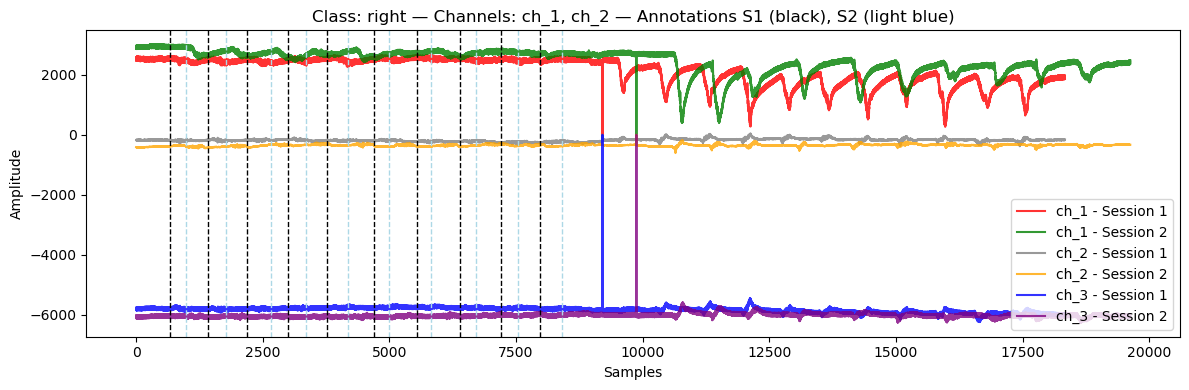

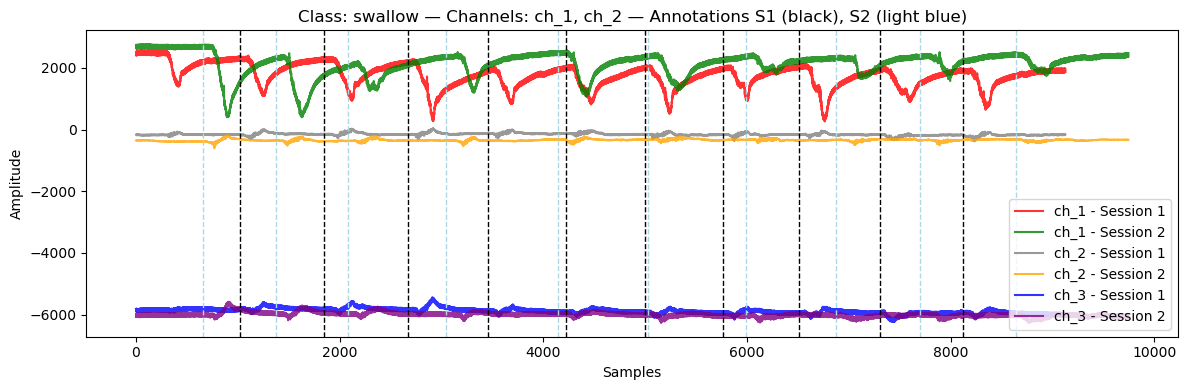

 Could not process annotations for nolabel, session 1: [Errno 2] No such file or directory: 'C:/Quick_Disk/tonge_project/scripts/data/annotations\\Individual_annotation1_nolabel.csv'
 Could not process annotations for nolabel, session 2: [Errno 2] No such file or directory: 'C:/Quick_Disk/tonge_project/scripts/data/annotations\\Individual_annotation2_nolabel.csv'


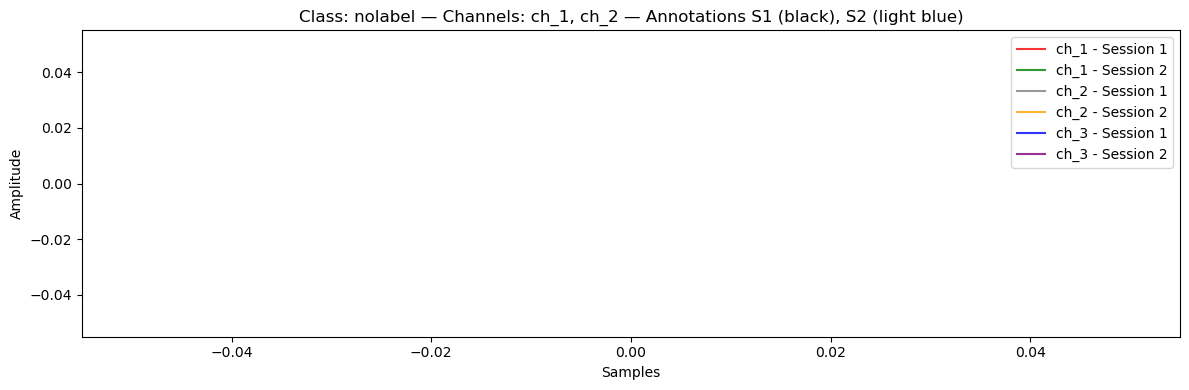

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np

annotation_base_path = "C:/Quick_Disk/tonge_project/scripts/data/annotations"

channels_to_plot = ["ch_1", "ch_2", "ch_3"]
session_colors = {
    1: {"ch_1": "red", "ch_2": "gray", "ch_3": "blue"},
    2: {"ch_1": "green", "ch_2": "orange", "ch_3": "purple"},
    3: {"ch_1": "yellow", "ch_2": "yellow", "ch_3": "yellow"}
}

class_labels = combined_df["label"].unique() # obtain array of unique class labels (all class names in the combined_df)

for label in class_labels:
    # Split data from combined_df, depending on the label and the session
    df1 = combined_df[(combined_df["label"] == label) & (combined_df["session"] == 1)].reset_index(drop=True)
    df2 = combined_df[(combined_df["label"] == label) & (combined_df["session"] == 2)].reset_index(drop=True)
    df3 = combined_df[(combined_df["label"] == label) & (combined_df["session"] == 3)].reset_index(drop=True)

    # Obtain timestamps from annotations
    def get_annotation_indices(df, label, session_num):
        annotation_file = os.path.join(annotation_base_path, f"Individual_annotation{session_num}_{label}.csv")
        try:
            annotations = pd.read_csv(annotation_file)
            logger_timestamps = annotations.iloc[:, 1].values
            emg_timestamps = df["ch_22"].values 
            return [(np.abs(emg_timestamps - ts)).argmin() for ts in logger_timestamps]
        except Exception as e:
            print(f" Could not process annotations for {label}, session {session_num}: {e}")
            return []

    sample_indices_s1 = get_annotation_indices(df1, label, session_num=1)
    sample_indices_s2 = get_annotation_indices(df2, label, session_num=2)

    # Plot data
    plt.figure(figsize=(12, 4))
    
    for ch in channels_to_plot:
        plt.plot(df1[ch], label=f"{ch} - Session 1", color=session_colors[1][ch], alpha=0.8)
        plt.plot(df2[ch], label=f"{ch} - Session 2", color=session_colors[2][ch], alpha=0.8)
        #plt.plot(df3[ch], label=f"{ch} - Session 3", color=session_colors[3][ch], alpha=0.8)

    # Vertical lines for annotations
    for idx in sample_indices_s1:
        plt.axvline(x=idx, color='black', linestyle='--', linewidth=1, label='_nolegend_')
    for idx in sample_indices_s2:
        plt.axvline(x=idx, color='lightblue', linestyle='--', linewidth=1, label='_nolegend_')

    plt.title(f"Class: {label} — Channels: ch_1, ch_2 — Annotations S1 (black), S2 (light blue)")
    plt.xlabel("Samples")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.tight_layout()
    plt.show()



# Create windows

In [137]:
import numpy as np
import os
import pandas as pd  

annotation_base_path = "C:/Quick_Disk/tonge_project/scripts/data/annotations"

# Class labels
windowed_data = {'l': [], 'lf': [], 'f': [], 'rf': [], 'r': [], 's': [], 'n': []}
windowed_data_test = {'l': [], 'lf': [], 'f': [], 'rf': [], 'r': [], 's': [], 'n': []}

window_size = 250  
skip_initial = 0

# ----------- Windows from one class recordings
# Map your class_labels from the ones in combined_df to short ones
class_map = {
    'left': 'l',
    'left_front': 'lf',
    'front': 'f',
    'right_front': 'rf',
    'right': 'r',
    'swallow': 's',
    'none': 'n'
}

def extract_windows(class_label, session_num):
    df = combined_df[(combined_df['label'] == class_label) & (combined_df['session'] == session_num)].reset_index(drop=True)

    annotation_file = os.path.join(annotation_base_path, f"Individual_annotation{session_num}_{class_label}.csv")
    
    try:
        annotations = pd.read_csv(annotation_file)
    except Exception as e:
        print(f"Could not read annotation file for {class_label}, session {session_num}: {e}")
        return []

    emg_timestamp = df['ch_22'].values
    windows = []

    for ts in annotations.iloc[:, 1].values:
        if len(emg_timestamp) == 0:
            continue
        start_idx = (np.abs(emg_timestamp - ts)).argmin() + skip_initial
        end_idx = start_idx + window_size

        if end_idx <= len(df):
            window = df.loc[start_idx:end_idx-1, ['ch_1', 'ch_2', 'ch_3']].values
            windows.append(window)
        else:
            print("Window not appended")

    return windows

# Get windows for each class (long_label) and store them with short_label
for long_label, short_label in class_map.items():
    one_class_train = []
    one_class_test = []

    for session in [1]: # Get samples of that label from recordings 1 and 2. 
        windows = extract_windows(long_label, session)
        one_class_train.extend(windows)
        #print(f"--- Session {session}: Train Class '{long_label}' has {len(windows)} windows. Total train windows: {len(one_class_train)}")

    for session in [2,3]:
        one_class_test.extend(extract_windows(long_label, session))

    windowed_data[short_label] = one_class_train # Store all samples of that label
    windowed_data_test[short_label] = one_class_test

print("Acquired windows for individual classes")

print("---- Train windows")
for long_label, short_label in class_map.items():
    print(f"Class '{short_label}': {len(windowed_data[short_label])} windows.")

print("\n---- Test windows")
for long_label, short_label in class_map.items():
    print(f"Class '{short_label}': {len(windowed_data_test[short_label])} windows.")


Acquired windows for individual classes
---- Train windows
Class 'l': 10 windows.
Class 'lf': 12 windows.
Class 'f': 10 windows.
Class 'rf': 10 windows.
Class 'r': 10 windows.
Class 's': 10 windows.
Class 'n': 10 windows.

---- Test windows
Class 'l': 20 windows.
Class 'lf': 20 windows.
Class 'f': 20 windows.
Class 'rf': 20 windows.
Class 'r': 20 windows.
Class 's': 20 windows.
Class 'n': 21 windows.


## Plot raw windows (only Train)

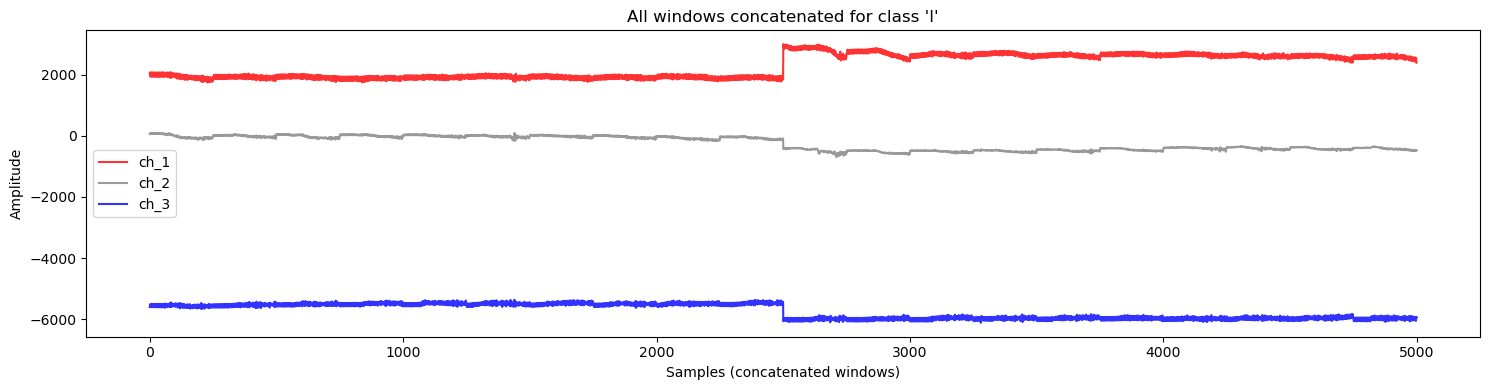

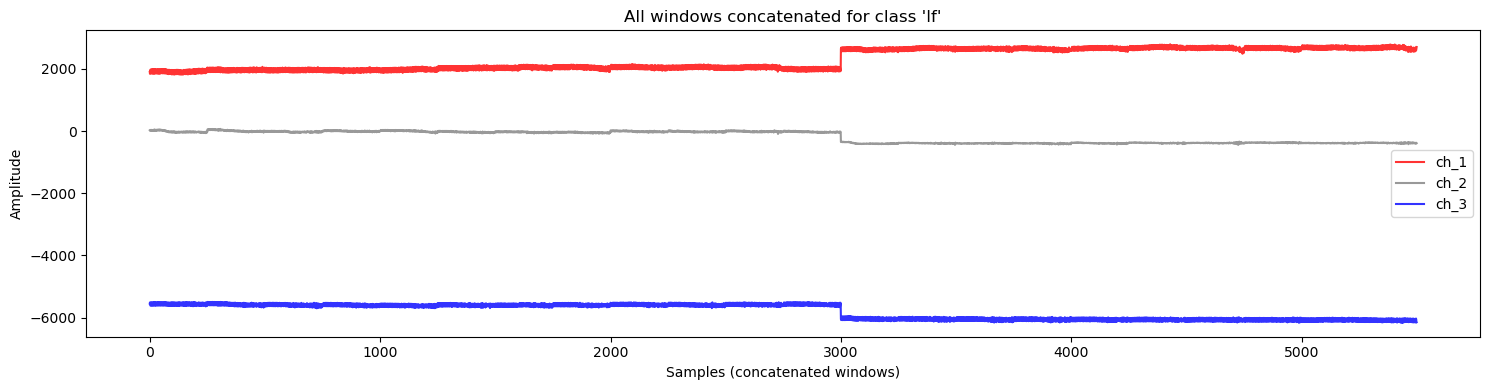

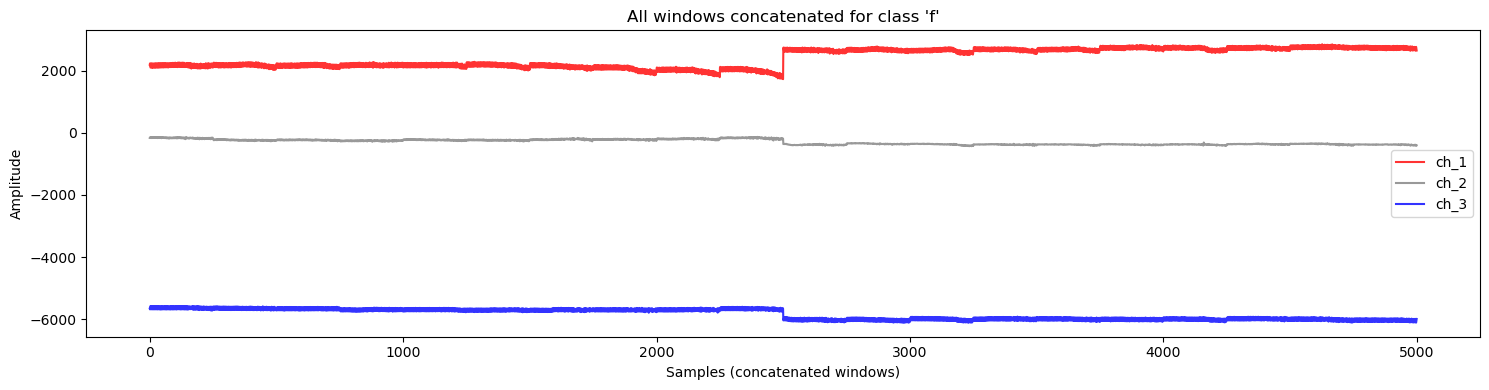

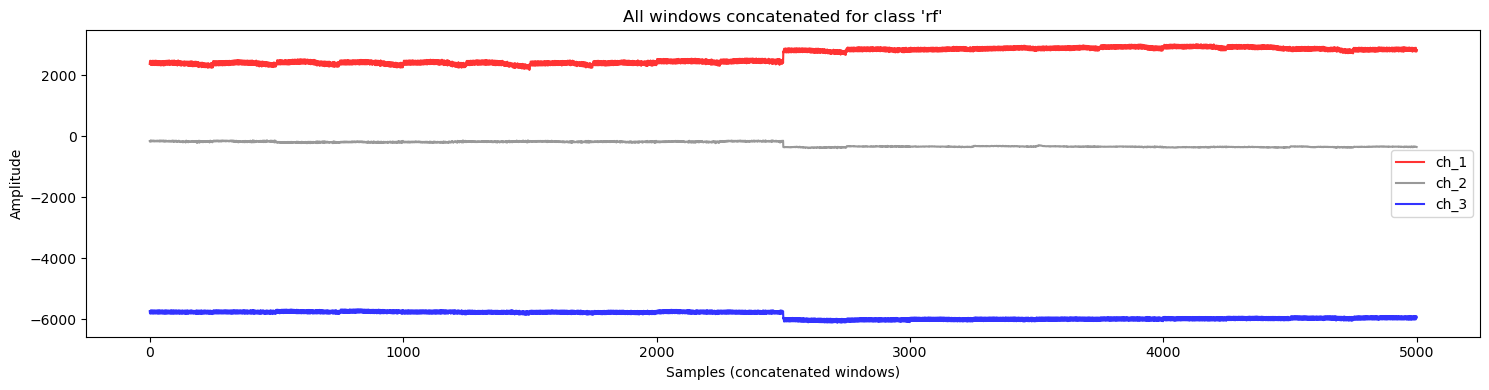

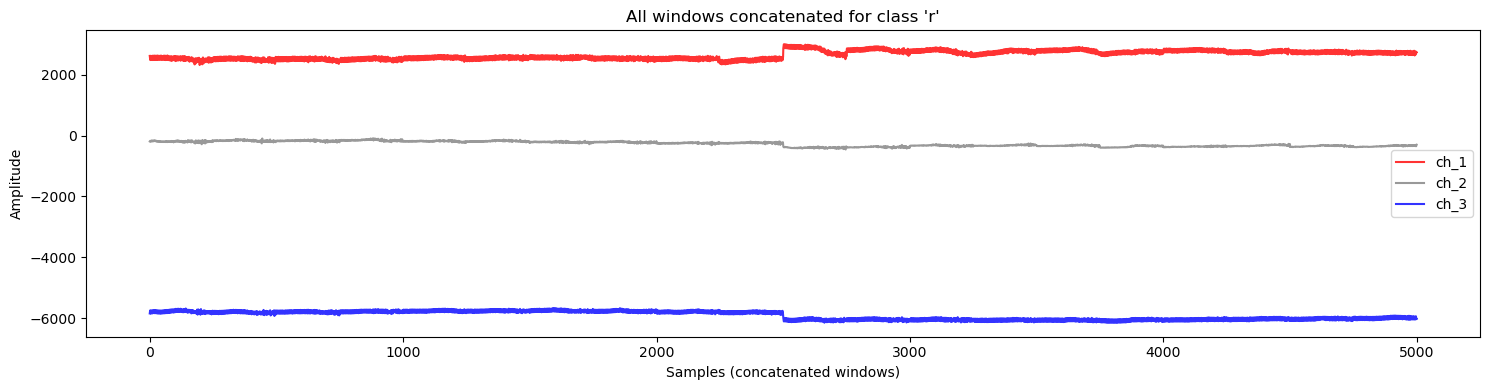

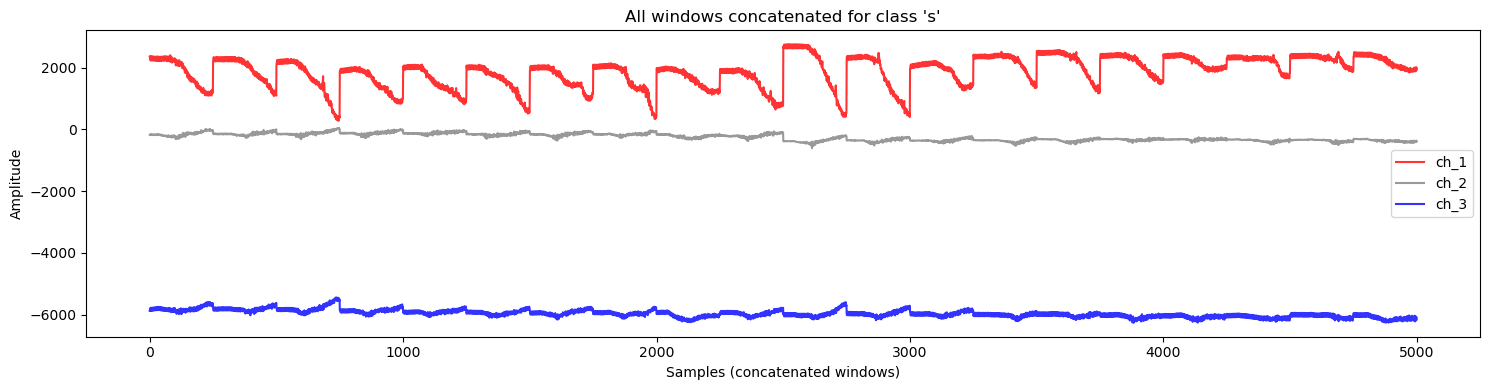

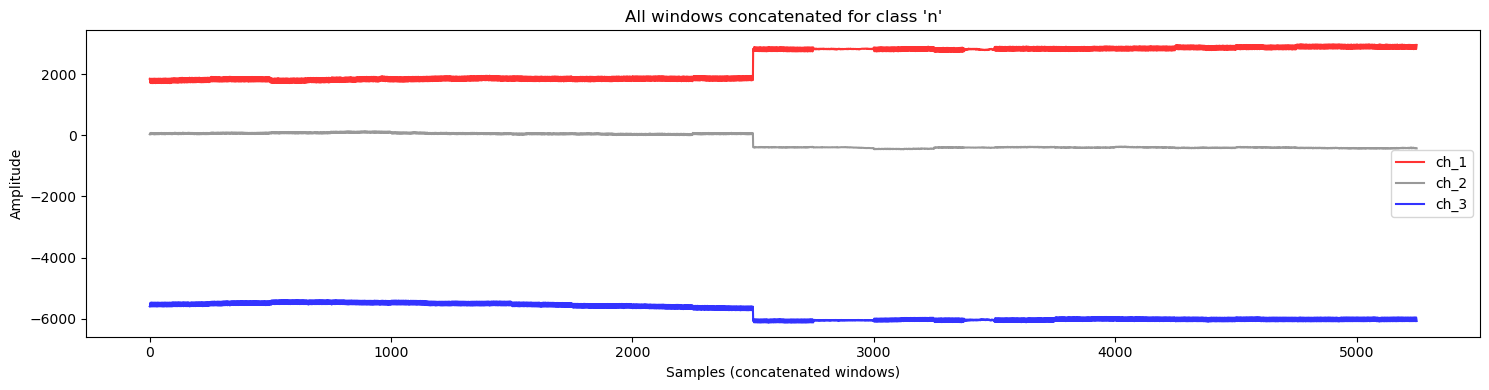

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# Colors for channels
channel_colors = {'ch_1': 'red', 'ch_2': 'gray', 'ch_3': 'blue'}
channels = ['ch_1', 'ch_2', 'ch_3']

for class_label, windows in windowed_data.items():
    if not windows:
        print(f"No windows for class '{class_label}', skipping plot.")
        continue
    
    # Concatenate all windows along time axis (axis=0)
    # Each window shape: (samples, 3 channels)
    concatenated = np.vstack(windows)  # shape: (num_windows * samples, 3)
    
    plt.figure(figsize=(15, 4))
    
    for i, ch in enumerate(channels):
        plt.plot(concatenated[:, i], color=channel_colors[ch], label=ch, alpha=0.8)
    
    plt.title(f"All windows concatenated for class '{class_label}'")
    plt.xlabel("Samples (concatenated windows)")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.tight_layout()
    plt.show()


## Filter windows

In [138]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import butter, filtfilt, iirnotch

def bandpass_filter(data, lowcut=5.0, highcut=35.0, fs=250.0, order=4):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data)

def high_pass_filter(signal, cutoff=0.1, fs=250, order=4):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    filtered_signal = filtfilt(b, a, signal)
    return filtered_signal

def notch_filter(signal, freq=50.0, fs=250, quality=30):
    nyquist = 0.5 * fs
    norm_freq = freq / nyquist
    b, a = iirnotch(norm_freq, quality)
    filtered_signal = filtfilt(b, a, signal)
    return filtered_signal

def compute_envelope(signal, fs=250, cutoff=5.0):
    rectified = np.abs(signal)
    b, a = butter(4, cutoff / (0.5 * fs), btype='low')
    envelope = filtfilt(b, a, rectified)
    return envelope

def filter_dataset(dataset, dataset_name=""):
    filtered_dataset = {}

    for class_label, windows in dataset.items():
        if not windows:
            print(f"No windows for class '{class_label}' in {dataset_name}, skipping filter.")
            continue
        
        fwindows = []
        for window in windows:
            if window.shape[0] <= 30:
                print(f"Skipping short window of length {window.shape[0]} for class '{class_label}'")
                continue
            one_window = window.copy()
            for i in range(window.shape[1]): 
                if i in [0, 1, 2]:  # Filter ONLY CHANNELS 1, 2 AND 3

                    if USE_NOTCH == 1:
                        one_window[:, i] = bandpass_filter(one_window[:, i])
                        
                    if USE_BANDPASS == 1:
                        one_window[:, i] = bandpass_filter(one_window[:, i])

                    if USE_ENVELOPE == 1:
                        one_window[:, i] = compute_envelope(one_window[:, i])

                    if USE_ZSCORE == 1:
                        mean = one_window[:, i].mean()
                        std = one_window[:, i].std()
                        if std == 0:
                            std = 1
                        one_window[:, i] = (one_window[:, i] - mean) / std
                        
                    if USE_ALIGNZERO_LOCAL == 1:
                        mean = one_window[:, i].mean()
                        one_window[:, i] = one_window[:, i] - mean
                        
            fwindows.append(one_window)

        filtered_dataset[class_label] = fwindows

    print(f"Filtering completed for {dataset_name}")
    return filtered_dataset

# Filter train and test datasets
filtered = filter_dataset(windowed_data, "train set")
filtered_test = filter_dataset(windowed_data_test, "test set")


Filtering completed for train set
Filtering completed for test set


## Plot filtered windows (only Train)

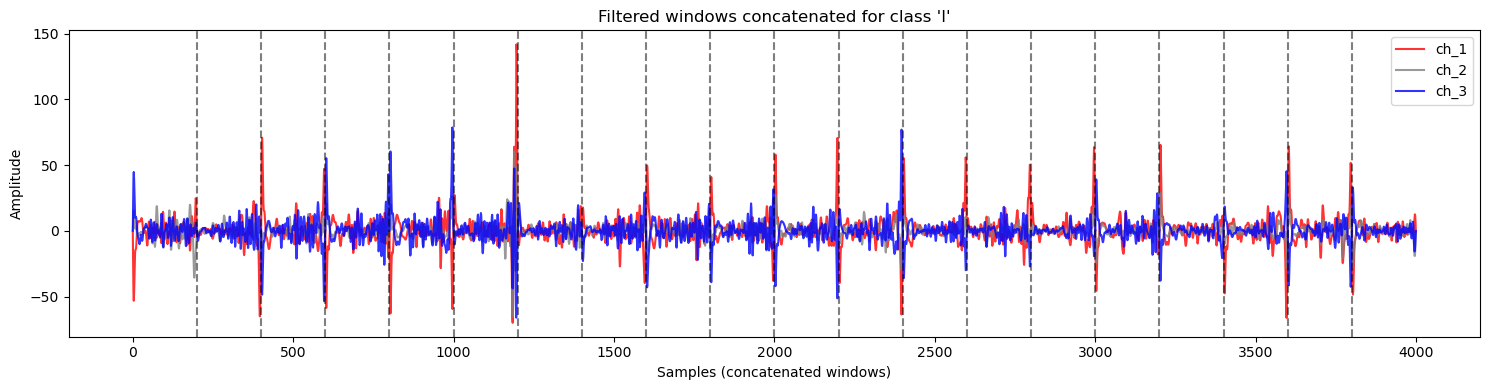

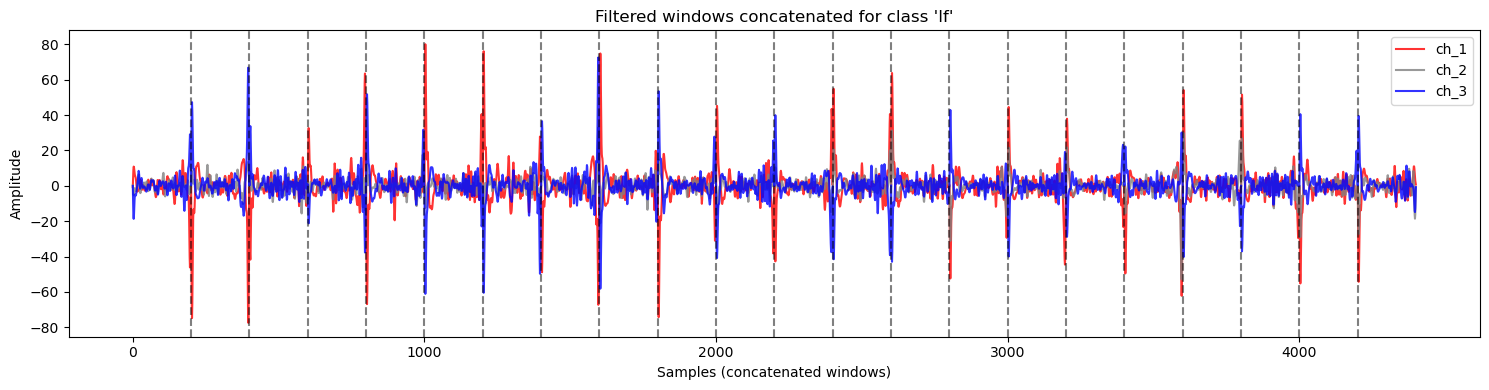

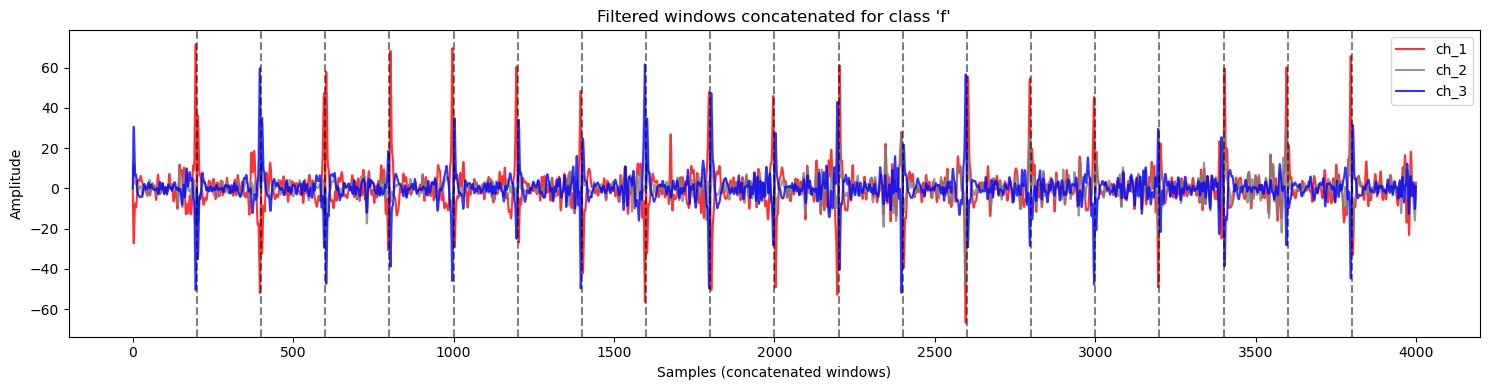

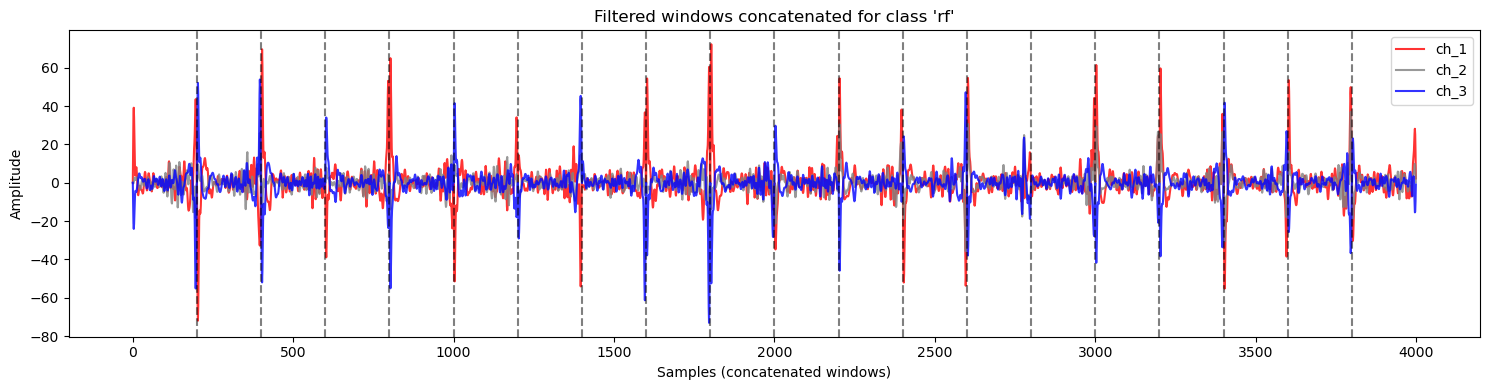

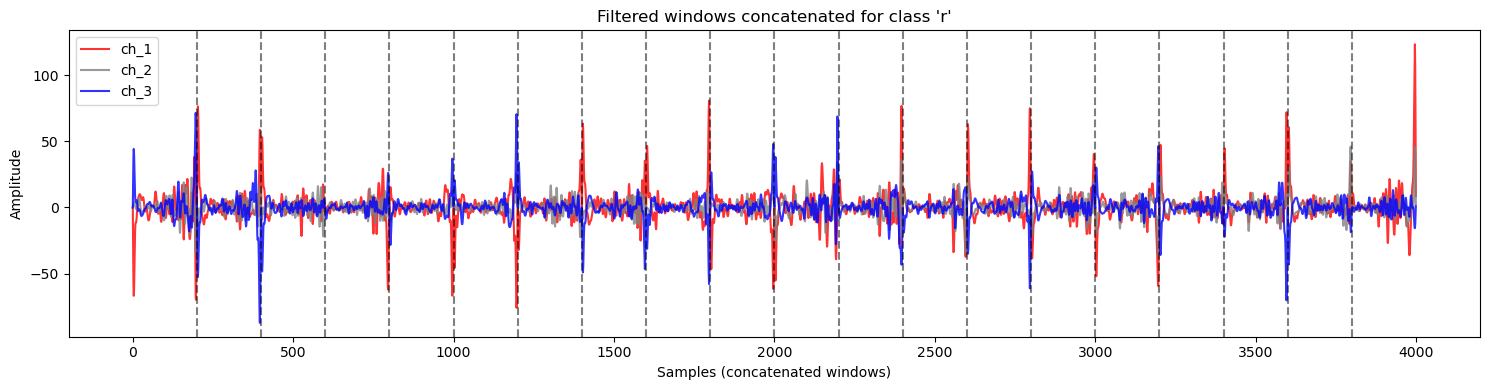

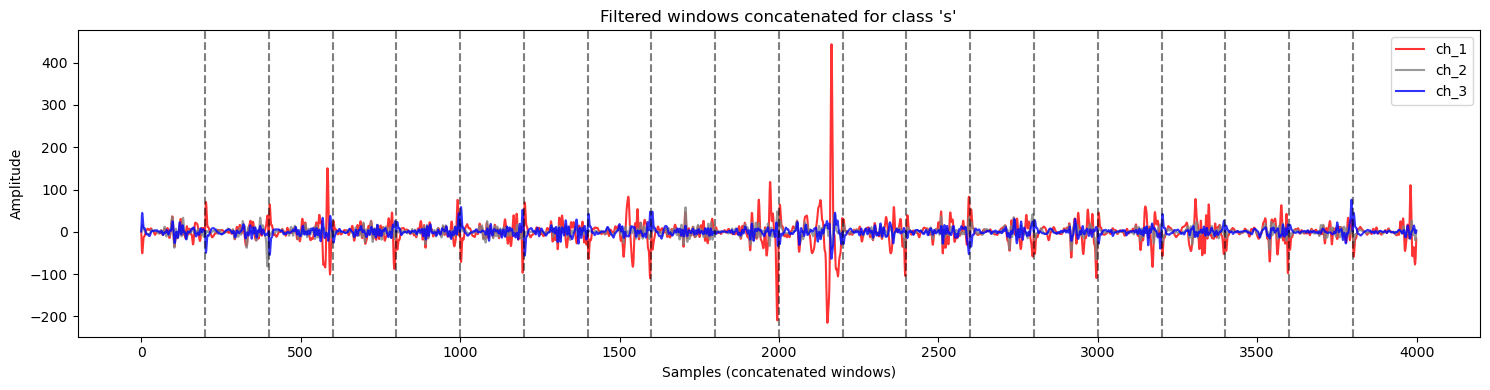

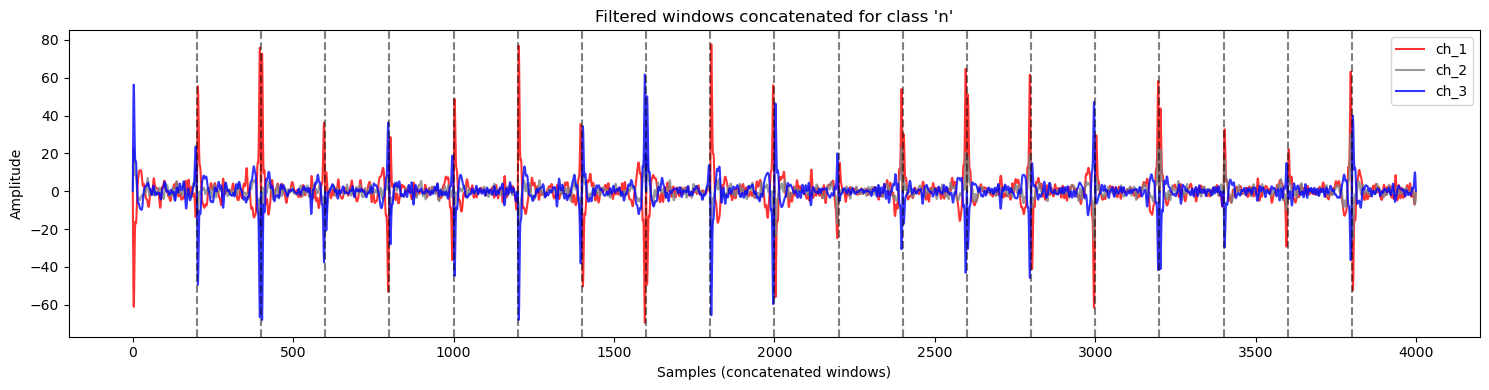

In [115]:
# Colors for channels
channel_colors = {'ch_1': 'red', 'ch_2': 'gray', 'ch_3': 'blue'}
channels = ['ch_1', 'ch_2', 'ch_3']

# For each label...
for class_label, windows in filtered.items():
    if not windows:
        continue

    #... concatenate
    concatenated = np.vstack(windows)
    plt.figure(figsize=(15, 4))

    # Plot each channel
    for i, ch in enumerate(channels):
        plt.plot(concatenated[:, i], color=channel_colors[ch], label=ch, alpha=0.8)
    
    # Add vertical lines between windows
    window_length = windows[0].shape[0]  # samples per window
    num_windows = len(windows)
    for w in range(1, num_windows):
        plt.axvline(x=w * window_length, color='black', linestyle='--', alpha=0.5)
    
    plt.title(f"Filtered windows concatenated for class '{class_label}'")
    plt.xlabel("Samples (concatenated windows)")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.tight_layout()
    plt.show()


## Plot filtered windows (only Test)

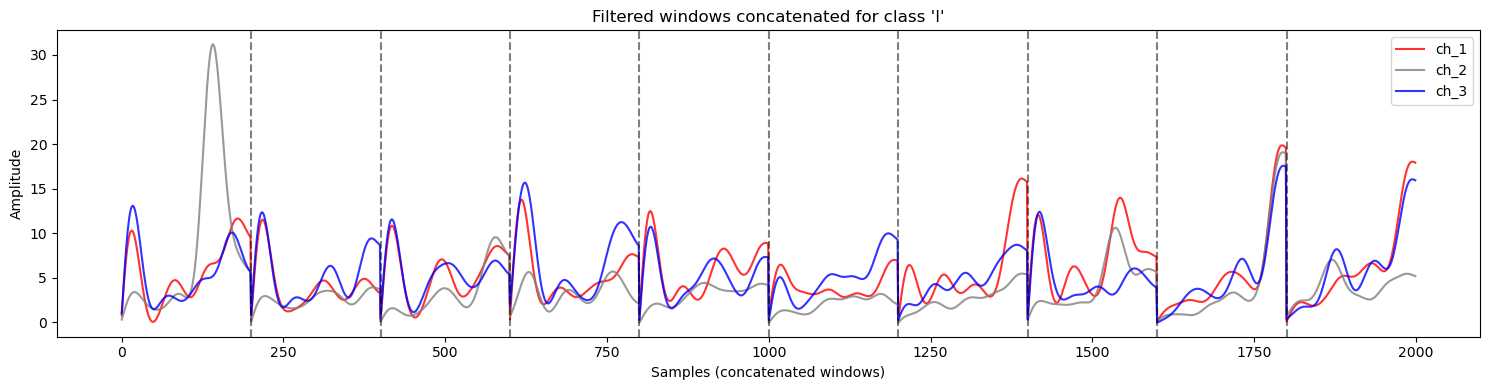

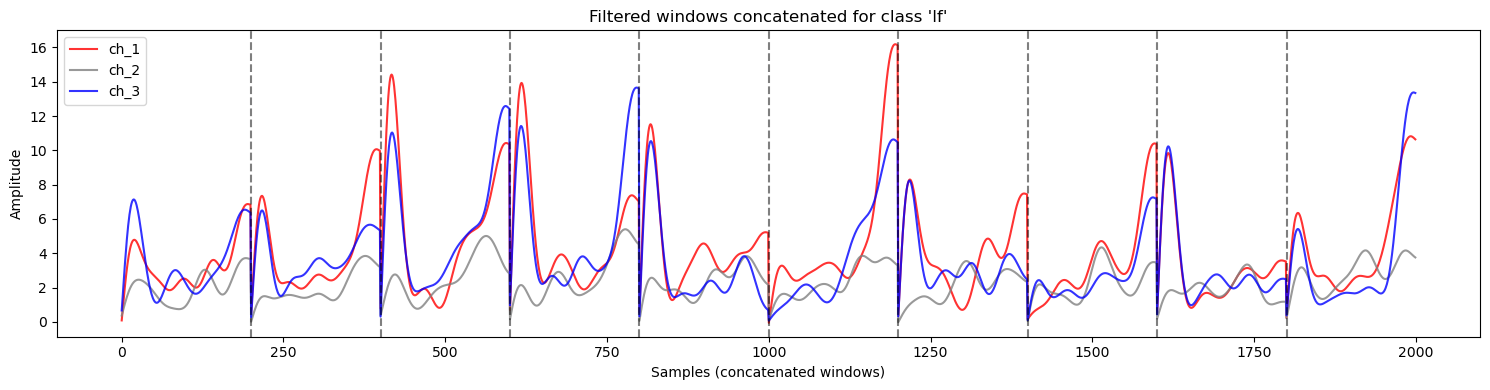

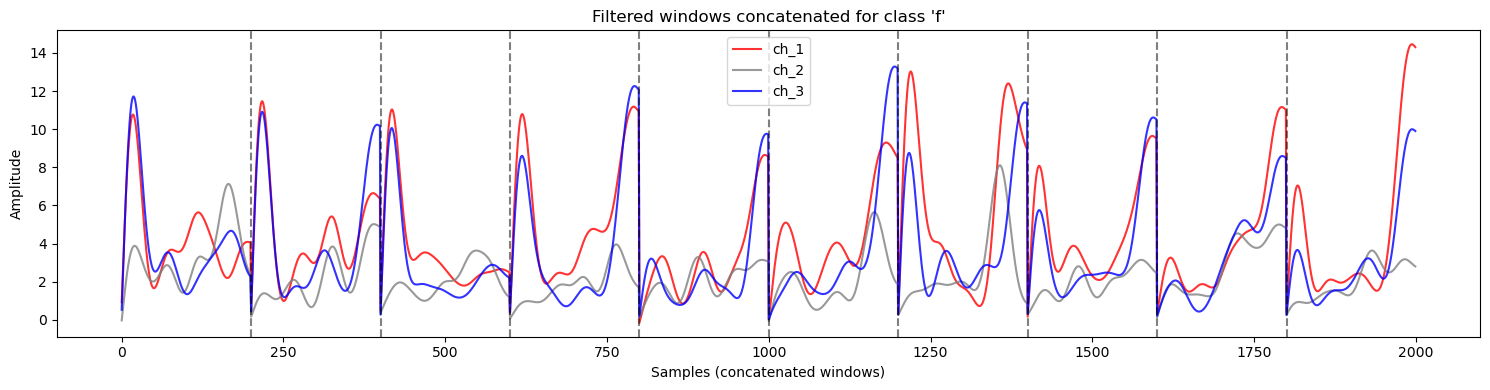

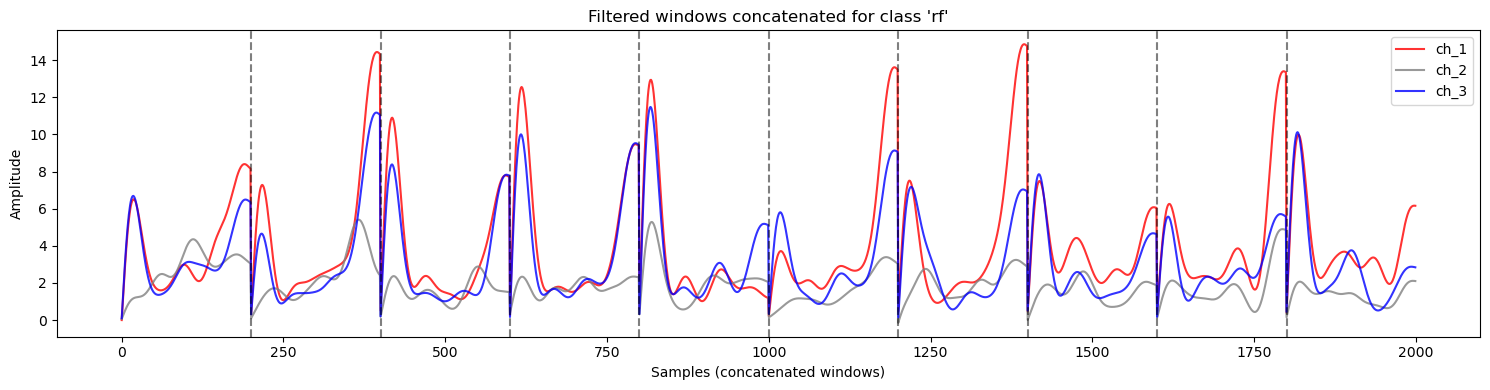

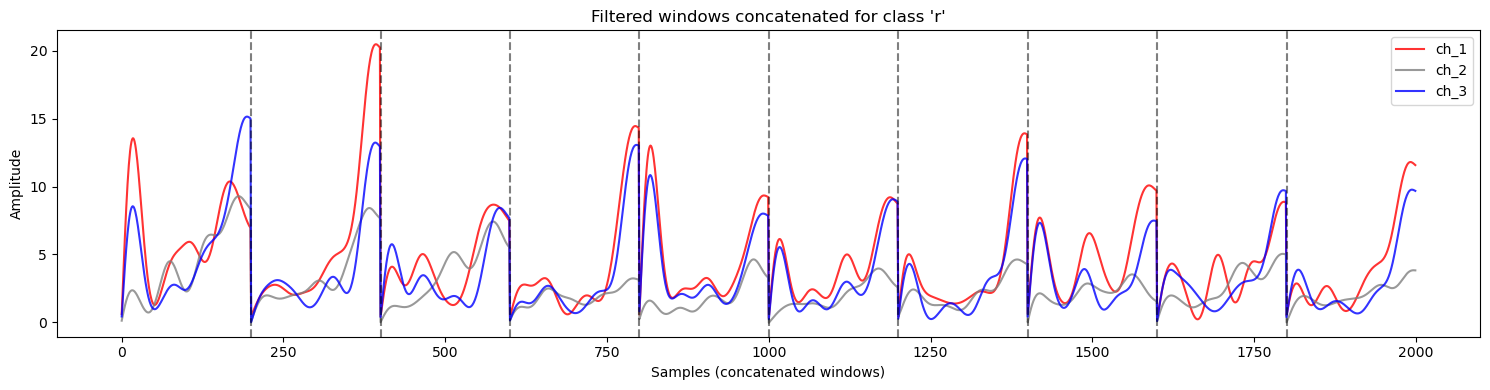

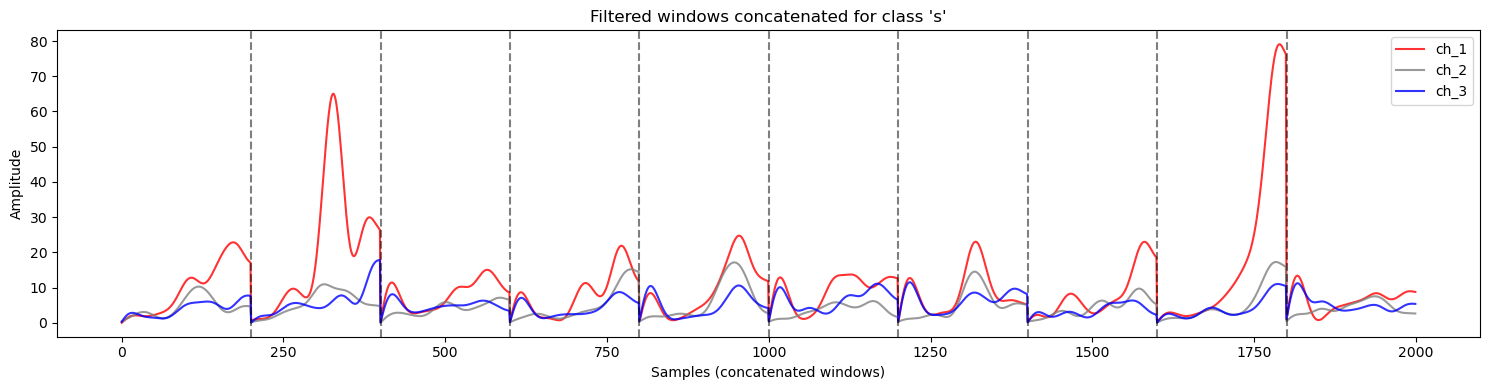

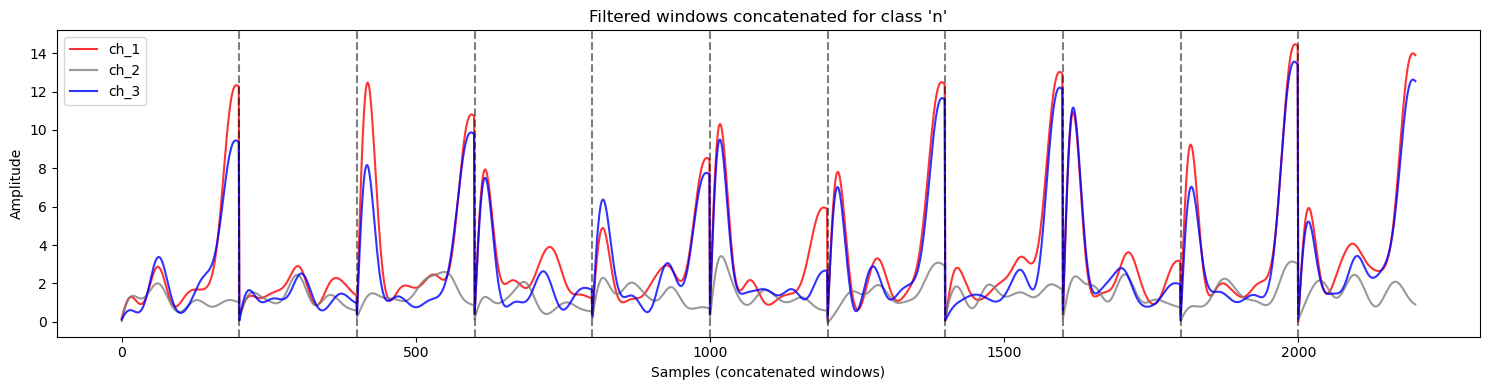

In [104]:
# Colors for channels
channel_colors = {'ch_1': 'red', 'ch_2': 'gray', 'ch_3': 'blue'}
channels = ['ch_1', 'ch_2', 'ch_3']

# For each label...
for class_label, windows in filtered_test.items():
    if not windows:
        continue

    #... concatenate
    concatenated = np.vstack(windows)
    plt.figure(figsize=(15, 4))

    # Plot each channel
    for i, ch in enumerate(channels):
        plt.plot(concatenated[:, i], color=channel_colors[ch], label=ch, alpha=0.8)
    
    # Add vertical lines between windows
    window_length = windows[0].shape[0]  # samples per window
    num_windows = len(windows)
    for w in range(1, num_windows):
        plt.axvline(x=w * window_length, color='black', linestyle='--', alpha=0.5)
    
    plt.title(f"Filtered windows concatenated for class '{class_label}'")
    plt.xlabel("Samples (concatenated windows)")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.tight_layout()
    plt.show()


# Feature extraction

In [139]:
import numpy as np
import pandas as pd

# -------------- Feature functions 
def rms(signal):
    return np.sqrt(np.mean(signal**2))

def zero_crossings(signal):
    signs = np.sign(signal)
    for i in range(1, len(signs)):
        if signs[i] == 0:
            signs[i] = signs[i-1] if signs[i-1] != 0 else 1
    return np.sum(np.diff(signs) != 0)

def waveform_length(signal):
    return np.sum(np.abs(np.diff(signal)))

def mav(signal):
    return np.mean(np.abs(signal))

def iav(signal):
    return np.sum(np.abs(signal))

def rms_signed_difference(signal):
    mean_val = np.mean(signal)
    diff = signal - mean_val
    return np.sqrt(np.mean(diff**2))

def mean_frequency(signal, fs=250):
    # Compute FFT
    freqs = np.fft.rfftfreq(len(signal), d=1/fs)
    fft_vals = np.abs(np.fft.rfft(signal))
    power = fft_vals ** 2
    if np.sum(power) == 0:
        return 0
    mf = np.sum(freqs * power) / np.sum(power)
    return mf

# -------------------

class_labels = ['l', 'lf', 'f', 'rf', 'r', 's', 'n']
channels = ['ch_1', 'ch_2', 'ch_3']
feature_names = ['RMS', 'RMS_SD', 'ZC', 'WL', 'MAV', 'STD', 'VAR', 'IAV']

def extract_features(filtered_data):
    features = []
    labels = []

    for label in class_labels:
        for window in filtered_data.get(label, []):
            feats = []
            for ch_idx in range(len(channels)):
                ch_signal = window[:, ch_idx]
                feats.append(rms(ch_signal))
                feats.append(rms_signed_difference(ch_signal))
                feats.append(zero_crossings(ch_signal))
                feats.append(waveform_length(ch_signal))
                feats.append(mav(ch_signal))
                feats.append(np.std(ch_signal))
                feats.append(np.var(ch_signal))
                feats.append(iav(ch_signal))
                
            features.append(feats)
            labels.append(label)

    cols = []
    for ch in channels:
        for feat_name in feature_names:
            cols.append(f"{ch}_{feat_name}")

    X = pd.DataFrame(features, columns=cols)
    y = pd.Series(labels, name='label')
    return X, y

# Extract features for train and test
X, y = extract_features(filtered)
Xt, yt = extract_features(filtered_test)

print("--- Train:")
print(X.head())
print(y.head())

print("\n--- Test:")
print(Xt.head())
print(yt.head())


--- Train:
    ch_1_RMS  ch_1_RMS_SD  ch_1_ZC     ch_1_WL  ch_1_MAV   ch_1_STD  \
0   9.090417     9.033658       38  728.447619  6.255061   9.033658   
1   7.294312     7.265779       32  557.184999  4.726662   7.265779   
2  14.341662    14.166596       36  860.625315  7.688291  14.166596   
3  11.305184    11.176083       32  732.458970  7.038179  11.176083   
4  13.346092    13.200374       32  873.881670  8.171151  13.200374   

     ch_1_VAR     ch_1_IAV  ch_2_RMS  ch_2_RMS_SD  ...   ch_2_VAR  \
0   81.606973  1563.765212  8.201294     8.196507  ...  67.182724   
1   52.791549  1181.665415  5.042557     5.040644  ...  25.408091   
2  200.692435  1922.072795  6.354898     6.343240  ...  40.236691   
3  124.904836  1759.544865  5.546937     5.545855  ...  30.756512   
4  174.249885  2042.787686  6.671639     6.661265  ...  44.372448   

      ch_2_IAV   ch_3_RMS  ch_3_RMS_SD  ch_3_ZC     ch_3_WL  ch_3_MAV  \
0  1593.560146   7.959466     7.919238       44  725.069853  5.544628   
1

# Classification

## Random Forest Tree

Random Forest Test Accuracy: 0.727


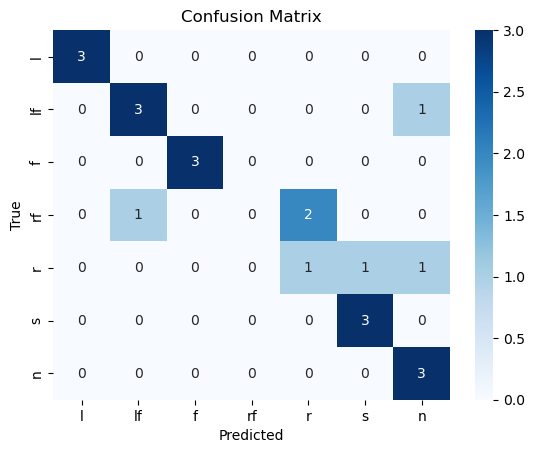

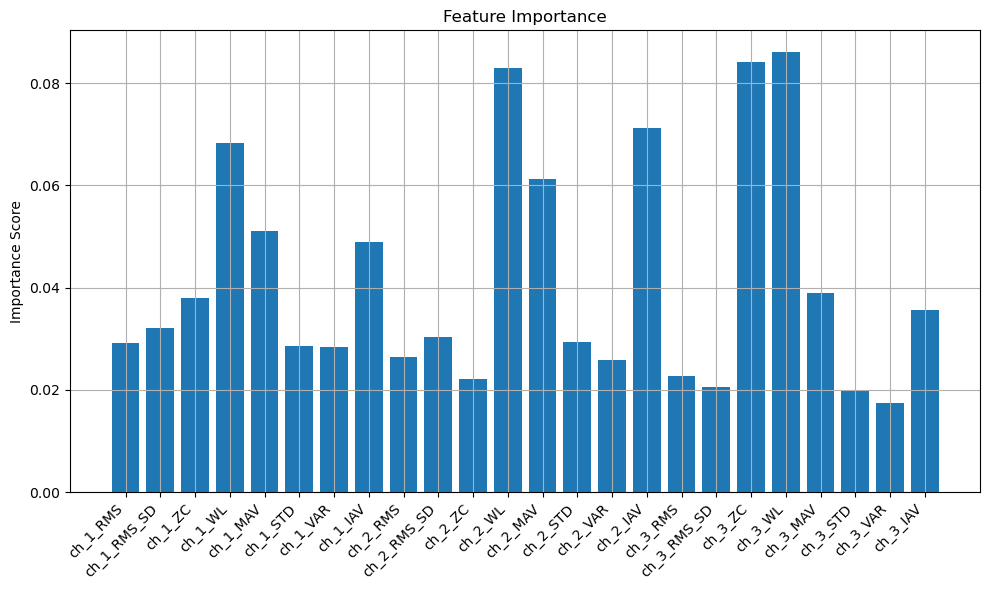

In [140]:
# ------------------------------- RANDOM FOREST TREE

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

# 1. Split data 
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# 2. Scale features
scaler_RF = StandardScaler()
X_train_scaled_array = scaler_RF.fit_transform(X_train)
X_test_scaled_array = scaler_RF.transform(X_test)

# Wrap back into DataFrames with feature names
X_train_scaled = pd.DataFrame(X_train_scaled_array, columns=X.columns)
X_test_scaled = pd.DataFrame(X_test_scaled_array, columns=X.columns)

# 3. Train & 4. Pred
clf_RF = RandomForestClassifier(n_estimators=500, random_state=42)
if USE_SCALING == 1:
    clf_RF.fit(X_train_scaled, y_train) # with scaling
    y_pred = clf_RF.predict(X_test_scaled)
else:
    clf_RF.fit(X_train, y_train)
    y_pred = clf_RF.predict(X_test)

# 5. Evaluate
acc = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred, labels=['l', 'lf', 'f', 'rf', 'r', 's', 'n'])

print(f"Random Forest Test Accuracy: {acc:.3f}")

# 6. Plot confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['l', 'lf', 'f', 'rf', 'r', 's', 'n'],
            yticklabels=['l', 'lf', 'f', 'rf', 'r', 's', 'n'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# 7. Plot feature importance
importances = clf_RF.feature_importances_
feature_names = X.columns if hasattr(X, 'columns') else [f'feat{i}' for i in range(X.shape[1])]

plt.figure(figsize=(10,6))
plt.bar(feature_names, importances)
plt.title("Feature Importance")
plt.ylabel("Importance Score")
plt.xticks(rotation=45, ha='right')
plt.grid(True)
plt.tight_layout()
plt.show()

# 8. Save model and scaler
#joblib.dump(clf_RF, "6_classes_rf.pkl")
#joblib.dump(scaler_RF, "6_classes_scaler_rf.pkl")


## PCA 

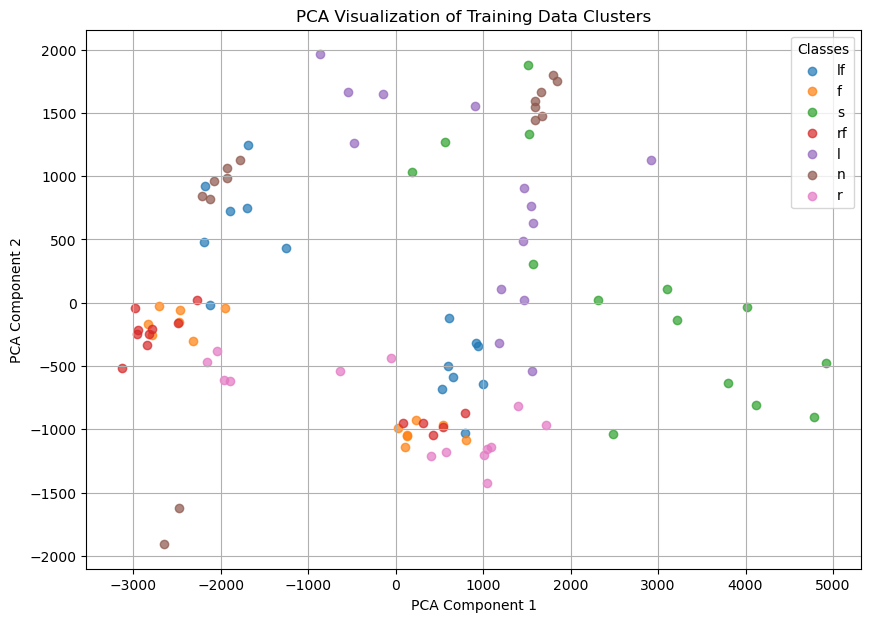

In [11]:
from sklearn.decomposition import PCA

# 2.5 PCA for visualization (2D)
pca = PCA(n_components=2)

if USE_SCALING == 1:
    X_train_pca = pca.fit_transform(X_train_scaled)
else:
    X_train_pca = pca.fit_transform(X_train)

# Plot
plt.figure(figsize=(10, 7))
for label in y_train.unique():
    idx = y_train == label
    plt.scatter(X_train_pca[idx, 0], X_train_pca[idx, 1], label=label, alpha=0.7)

plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('PCA Visualization of Training Data Clusters')
plt.legend(title='Classes')
plt.grid(True)
plt.show()


## SVM

SVM Test Accuracy: 0.279


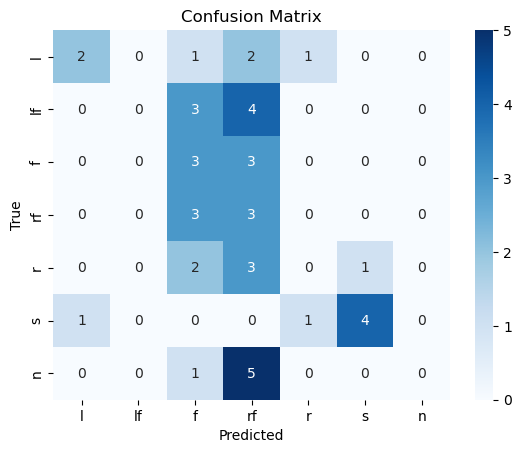

In [156]:
# ----------------------------- SUPPORT VECTOR MACHINE

from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
import pandas as pd

# 1. Split data 
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# 2. Scale features
scaler_SVM = StandardScaler()
X_train_scaled_array = scaler_SVM.fit_transform(X_train)
X_test_scaled_array = scaler_SVM.transform(X_test)

# Wrap back into DataFrames with feature names
X_train_scaled = pd.DataFrame(X_train_scaled_array, columns=X.columns)
X_test_scaled = pd.DataFrame(X_test_scaled_array, columns=X.columns)

# 3. Train & 4. Pred
clf_SVM = SVC(kernel='rbf', C=0.1, gamma='scale', class_weight='balanced')
if USE_SCALING == 1:
    clf_SVM.fit(X_train_scaled, y_train) # with scaling
    y_pred = clf_SVM.predict(X_test_scaled)
else:
    clf_SVM.fit(X_train, y_train)
    y_pred = clf_SVM.predict(X_test)

# 5. Evaluate
acc = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred, labels=['l', 'lf', 'f', 'rf', 'r', 's', 'n'])

print(f"SVM Test Accuracy: {acc:.3f}")

# 6. Plot confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['l', 'lf', 'f', 'rf', 'r', 's', 'n'],
            yticklabels=['l', 'lf', 'f', 'rf', 'r', 's', 'n'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# 7. Save model and scaler
#joblib.dump(clf_SVM, "7_classes_svm.pkl")
#joblib.dump(scaler, "scaler_SVM_svm.pkl")


## Logistic regresion

C:\Users\amebita\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\amebita\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Test Accuracy: 0.651


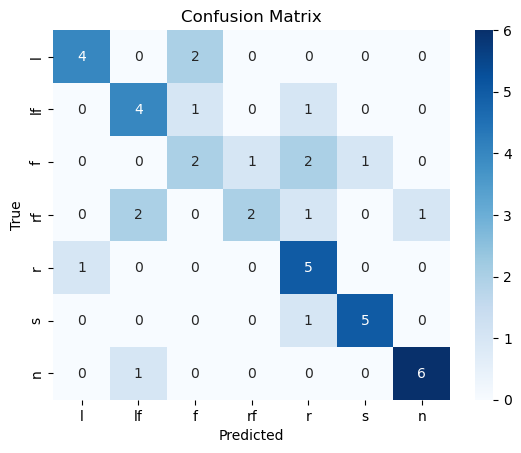

In [129]:
# ------------------------------- LOGISTIC REGRESSION

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

# 1. Split data 
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# 2. Scale features
scaler_LR = StandardScaler()
X_train_scaled_array = scaler_LR.fit_transform(X_train)
X_test_scaled_array = scaler_LR.transform(X_test)

# Wrap back into DataFrames with feature names
X_train_scaled = pd.DataFrame(X_train_scaled_array, columns=X.columns)
X_test_scaled = pd.DataFrame(X_test_scaled_array, columns=X.columns)

# 3. Train & 4. Pred
clf_LR = LogisticRegression(
    solver='lbfgs', 
    multi_class='multinomial', 
    class_weight='balanced',
    max_iter=1000,
    random_state=42
)

if USE_SCALING == 1:
    clf_LR.fit(X_train_scaled, y_train)  # with scaling
    y_pred = clf_LR.predict(X_test_scaled)
else:
    clf_LR.fit(X_train, y_train)
    y_pred = clf_LR.predict(X_test)

# 5. Evaluate
acc = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred, labels=['l', 'lf', 'f', 'rf', 'r', 's', 'n'])

print(f"Logistic Regression Test Accuracy: {acc:.3f}")

# 6. Plot confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['l', 'lf', 'f', 'rf', 'r', 's', 'n'],
            yticklabels=['l', 'lf', 'f', 'rf', 'r', 's', 'n'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# 7. Save model and scaler
#joblib.dump(clf_LR, "6_classes_lr.pkl")
#joblib.dump(scaler_LR, "6_classes_scaler_lr.pkl")


# Test

## Random Forest Tree

Random Forest Test Accuracy: 0.560


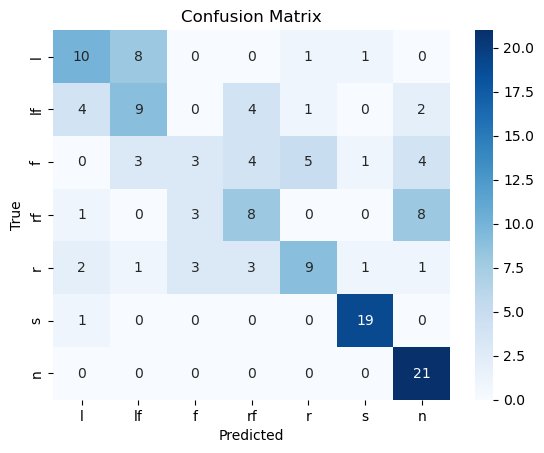

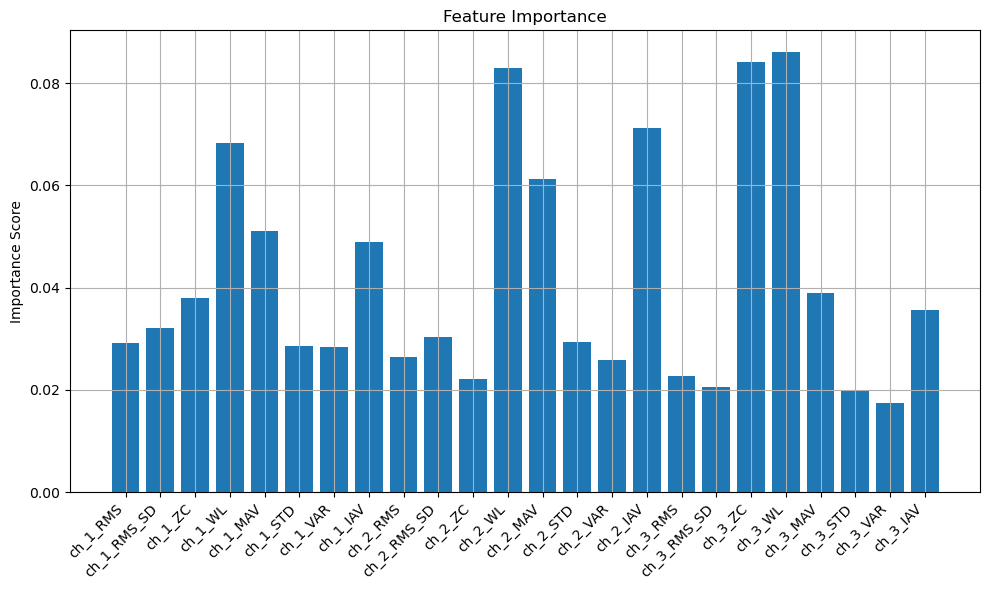

In [141]:
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

if USE_SCALING == 1:
    Xt_scaled_array = scaler_RF.transform(Xt)
    Xt_scaled = pd.DataFrame(Xt_scaled_array, columns=Xt.columns)
    y_pred = clf_RF.predict(Xt_scaled)
else:
    y_pred = clf_RF.predict(Xt)
    
# Evaluate accuracy
acc = accuracy_score(yt, y_pred)
print(f"Random Forest Test Accuracy: {acc:.3f}")

# Compute confusion matrix
labels_order = ['l', 'lf', 'f', 'rf', 'r', 's', 'n']
cm = confusion_matrix(yt, y_pred, labels=labels_order)

# Plot confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels_order,
            yticklabels=labels_order)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Plot feature importance
importances = clf_RF.feature_importances_
feature_names = Xt.columns if hasattr(Xt, 'columns') else [f'feat{i}' for i in range(Xt.shape[1])]

plt.figure(figsize=(10,6))
plt.bar(feature_names, importances)
plt.title("Feature Importance")
plt.ylabel("Importance Score")
plt.xticks(rotation=45, ha='right')
plt.grid(True)
plt.tight_layout()
plt.show()


## SVM

SVM Test Accuracy: 0.329


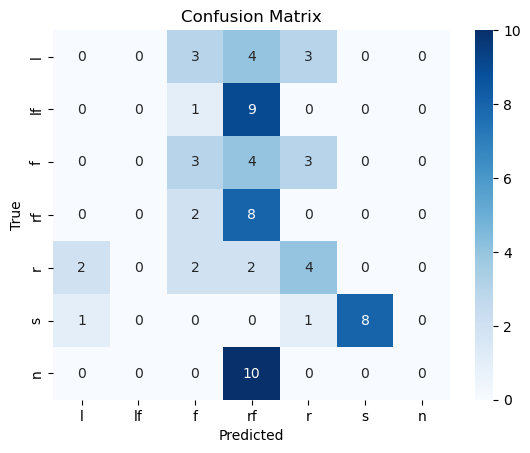

In [158]:
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

if USE_SCALING == 1:
    Xt_scaled_array = scaler_SVM.transform(Xt)
    Xt_scaled = pd.DataFrame(Xt_scaled_array, columns=Xt.columns)
    y_pred = clf_SVM.predict(Xt_scaled)
else:
    y_pred = clf_SVM.predict(Xt)
    
# Evaluate accuracy
acc = accuracy_score(yt, y_pred)
print(f"SVM Test Accuracy: {acc:.3f}")

# Compute confusion matrix
labels_order = ['l', 'lf', 'f', 'rf', 'r', 's', 'n']
cm = confusion_matrix(yt, y_pred, labels=labels_order)

# Plot confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels_order,
            yticklabels=labels_order)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


## Logistic regresion

Logistic Regression Test Accuracy: 0.493


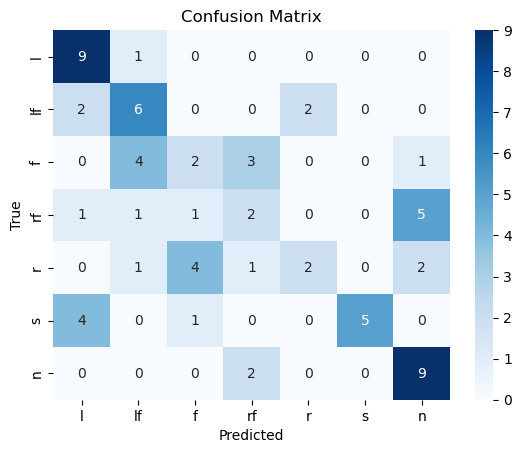

In [84]:
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

if USE_SCALING == 1:
    Xt_scaled_array = scaler_LR.transform(Xt)
    Xt_scaled = pd.DataFrame(Xt_scaled_array, columns=Xt.columns)
    y_pred = clf_LR.predict(Xt_scaled)
else:
    y_pred = clf_LR.predict(Xt)

# Evaluate accuracy
acc = accuracy_score(yt, y_pred)
print(f"Logistic Regression Test Accuracy: {acc:.3f}")

# Compute confusion matrix
labels_order = ['l', 'lf', 'f', 'rf', 'r', 's', 'n']
cm = confusion_matrix(yt, y_pred, labels=labels_order)

# Plot confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels_order,
            yticklabels=labels_order)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Optional: Plot coefficients if you want (commented out for now)
# coefs = clf_LR.coef_
# feature_names = Xt.columns if hasattr(Xt, 'columns') else [f'feat{i}' for i in range(Xt.shape[1])]
# plt.figure(figsize=(12,6))
# for i, class_label in enumerate(clf_LR.classes_):
#     plt.plot(feature_names, coefs[i], marker='o', label=f"Class {class_label}")
# plt.title("Logistic Regression Coefficients")
# plt.ylabel("Coefficient Value")
# plt.xticks(rotation=45, ha='right')
# plt.grid(True)
# plt.legend()
# plt.tight_layout()
# plt.show()
